In [2]:
import numpy as np
import pandas as pd
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm
import scipy
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import seaborn as sns
%matplotlib inline
#############
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
#######################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#WBC Blood Cell Classification:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

## Original Data is unbalanced among different cell types (classes)

[  3  88  33  21 207]


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Counts')

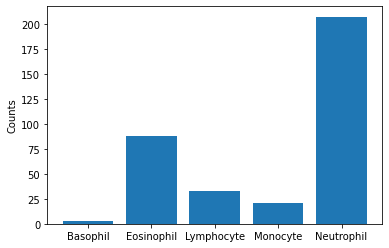

In [4]:
reader = csv.reader(open('data/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

## Augmented data (rotated, zoom-in + zoom-out, random crop, etc.) to make it balanced

In [5]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
#                     img_file = Image.fromarray(img_file).resize(size=(60,80,3))
#                     img_file = resize(img_file, (60,80,3)) #reduce the size of the picture
                    img_file = resize(img_file, (120,160,3)) #reduce the size of the picture
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

X_train, y_train, z_train = get_data('data/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('data/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(dict_characters)
print(dict_characters2)

100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [00:22<00:00, 27.32it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


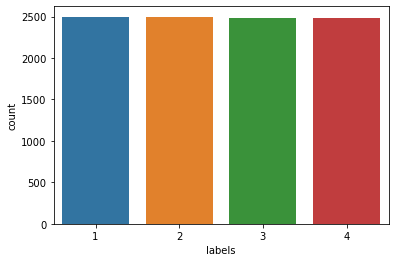

In [27]:
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [10]:
# # Covert Augmented Data to Torch
# X_train_torch = torch.from_numpy(X_train)
# X_train_torch = X_train_torch.reshape((X_train_torch.shape[0], 3,X_train_torch.shape[1],X_train_torch.shape[2]))
# y_train_torch = torch.from_numpy(y_train-1)
# z_train_torch = torch.from_numpy(z_train)

# X_test_torch = torch.from_numpy(X_test)
# X_test_torch = X_test_torch.reshape((X_test_torch.shape[0],3,X_test_torch.shape[1],X_test_torch.shape[2]))
# y_test_torch = torch.from_numpy(y_test-1)
# z_test_torch = torch.from_numpy(z_test)

# trainset_y = TensorDataset(X_train_torch, y_train_torch)
# trainset_z = TensorDataset(X_train_torch, z_train_torch)
# testset_y = TensorDataset(X_test_torch, y_test_torch)
# testset_z = TensorDataset(X_test_torch, z_test_torch)

# #Torch Data Loader:
# train_minibatch_size = 64
# test_minibatch_size = 128
# train_loader = DataLoader(trainset_y, batch_size = train_minibatch_size, shuffle = True)
# test_loader = DataLoader(testset_y, batch_size = test_minibatch_size, shuffle = True)

In [8]:
class BloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        return self.images[idx], self.labels[idx]

In [11]:
tfms = transforms.Compose([transforms.ToTensor()])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#normalize the input data
mean = tuple((X_train.mean(axis=(0,1,2))/255).round(4))
std = tuple((X_train.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean, std)])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#####################################
tfms = transforms.Compose([transforms.ToTensor()])
test = BloodDataset(X_test, y_test-1, transform=tfms)
mean = tuple((X_test.std(axis=(0,1,2))/255).round(4))
std = tuple((X_test.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean, std)])
test = BloodDataset(X_test, y_test-1, transform=tfms)
##################################
batch_size = 128
test_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=test_size, shuffle=True)

# Task2 : Classification of different cell types

In [12]:
#Train Function:
def train(epoch, model, train_loader):
    model.train()
    
    train_nb_batch = len(train_loader)
    train_loss = 0.0
    train_batch_loss = 0.0
    train_total_loss = 0.0
    train_acc = 0.0
    train_batch_acc = 0.0
    train_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(train_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        #zero that gradients buffer
        optimizer.zero_grad()
        #forward + backward + optimize
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        loss.backward()
        optimizer.step()

        train_batch_loss = loss.item()
        train_total_loss += train_batch_loss
        pred_batch_train = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_train = pred_batch_train
        if i >0:
            pred_train = torch.cat([pred_train, pred_batch_train], dim=0)
        train_batch_acc = accuracy_score(pred_batch_train,minibatch_y)
        train_total_acc += train_batch_acc
        
    train_loss = train_total_loss/train_nb_batch
    train_acc = train_total_acc/train_nb_batch
    scheduler.step()
    return pred_train, train_loss, train_acc

In [13]:
def test(epoch, model, test_loader):
    model.eval()
    
    test_nb_batch = len(test_loader)
    test_loss = 0.0
    test_batch_loss = 0.0
    test_total_loss = 0.0
    test_acc = 0.0
    test_batch_acc = 0.0
    test_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(test_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        test_batch_loss = loss.item()
        test_total_loss += test_batch_loss
        pred_batch_test = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_test = pred_batch_test
        if i >0:
            pred_test = torch.cat([pred_test, pred_batch_test], dim=0)
        test_batch_acc = accuracy_score(pred_batch_test,minibatch_y)
        test_total_acc += test_batch_acc
    test_loss = test_total_loss/test_nb_batch
    test_acc = test_total_acc/test_nb_batch
    return pred_test, test_loss, test_acc

### MobileNet-v2:

In [23]:
n_classes = 4
mobilenet = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
for param in mobilenet.features.parameters():
    param.requires_grad = False    
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Sequential(
                nn.Dropout(0.4),
                nn.Linear(num_ftrs, 4))  
#                 nn.ReLU(), 
#                 nn.Dropout(0.3),
#                 nn.Linear(16, 4),                   
#                 nn.Softmax(dim=1) )
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.0001)
# optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, amsgrad=False)
lr = 0.01
optimizer = optim.Adam(mobilenet.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=[10,20,40,60,80], gamma=0.2)

Using cache found in C:\Users\parshinshojaee/.cache\torch\hub\pytorch_vision_master


In [24]:
num_epoch = 20
train_losses = []
test_losses = []
train_accs = []
test_accs= []

for epoch in range(num_epoch):
    pred_train, train_loss, train_acc = train(epoch, mobilenet, train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    pred_test, test_loss, test_acc = test(epoch, mobilenet, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print("epoch:",epoch,"train loss:", train_loss, "train accuracy:", train_acc)
    print("epoch:",epoch,"test loss:", test_loss, "test accuracy:", test_acc)

epoch: 0 train loss: 1.6188783874878516 train accuracy: 0.5226005172632647
epoch: 0 test loss: 1.1468456596136094 test accuracy: 0.5576065340909091
epoch: 1 train loss: 0.8850777485431769 train accuracy: 0.6515266009774054
epoch: 1 test loss: 1.2007550686597823 test accuracy: 0.5852130681818182
epoch: 2 train loss: 0.904371623809521 train accuracy: 0.6534028703351105
epoch: 2 test loss: 1.381509780883789 test accuracy: 0.5266264204545454
epoch: 3 train loss: 0.9715404288891034 train accuracy: 0.6470461649530338
epoch: 3 test loss: 1.1680555552244187 test accuracy: 0.5697230113636363
epoch: 4 train loss: 0.9959539916270819 train accuracy: 0.6483482482863671
epoch: 4 test loss: 1.2282269418239593 test accuracy: 0.5782954545454546
epoch: 5 train loss: 1.0312576171679375 train accuracy: 0.6475201907209952
epoch: 5 test loss: 1.4698976218700408 test accuracy: 0.5513636363636364
epoch: 6 train loss: 1.0811659487394185 train accuracy: 0.6409234973978167
epoch: 6 test loss: 1.3704089283943177 

KeyboardInterrupt: 

In [25]:
print('Finished Training')
PATH = './Project_Task2_MobileNet-v2_20epoch_lr0001_nodropout.pkl'
torch.save(mobilenet, PATH)

Finished Training


In [26]:
np.save('train_losses_MobileNet_20epoch_dropout.npy', train_losses)
np.save('train_accs_MobileNet_20epoch_dropout.npy', train_accs)
np.save('test_losses_MobileNet_20epoch_dropout.npy', test_losses)
np.save('test_accs_MobileNet_20epoch_dropout.npy', test_accs)

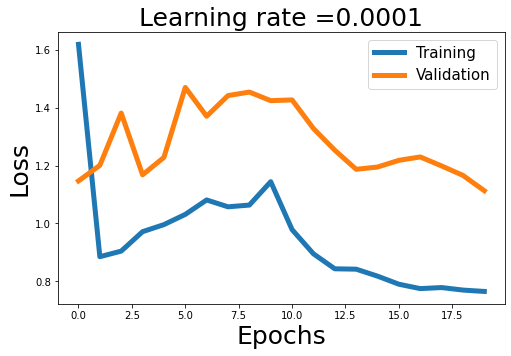

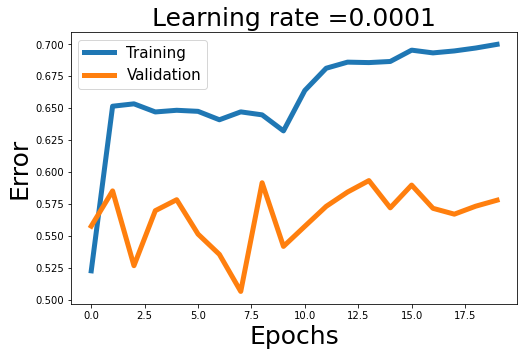

In [27]:
#Plot Train and Validation Loss 
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_losses[:20])),train_losses[:20], label='Training', linewidth=5)
plt.plot(np.arange(len(test_losses[:20])),test_losses[:20], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Loss',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_MobileNet-v2_loss.png')
plt.show() 

#Plot Train and Validation Errors
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_accs[:20])),train_accs[:20], label='Training', linewidth=5)
plt.plot(np.arange(len(test_accs[:20])),test_accs[:20], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Error',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_MobileNet-v2_error.png')
plt.show() 

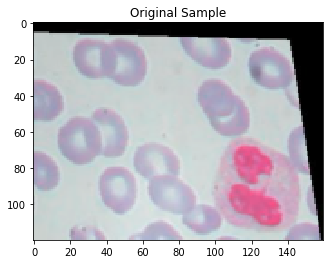

(120, 160, 3)
(3, 120, 160)
torch.Size([1, 3, 120, 160])


NameError: name 'model' is not defined

In [28]:
#select a random image sample
n_samples = len(X_test)
random_index = int(np.random.random()*n_samples)
random_sample = X_test[random_index]
plt.imshow(random_sample, interpolation='none')
plt.title("Original Sample")
plt.show()

print(random_sample.shape)
random_sample = np.transpose(random_sample, (2, 0, 1))
print(random_sample.shape)

X_sample = torch.from_numpy(random_sample)
X_sample = X_sample.unsqueeze(0)
print(X_sample.shape)
feature_map = mobilenet(X_sample.float())
# feature_layer1 = model.conv_layer1(X_sample.float())
# feature_layer2 = model.conv_layer2(feature_layer1)
# feature_layer3 = model.conv_layer3(feature_layer2)
# feature_layer1 = feature_layer1.detach().numpy()
# feature_layer2 = feature_layer2.detach().numpy()
# feature_layer3 = feature_layer3.detach().numpy()

print(feature_layer1.shape)
plt.imshow(np.transpose(feature_layer1[:,10,:,:], (1, 2, 0)), interpolation='none')
plt.title("Detected Feature Map-Layer1")
plt.show()
plt.imshow(np.transpose(feature_layer2[:,4,:,:], (1, 2, 0)), interpolation='none')
plt.title("Detected Feature Map-Layer2")
plt.show()
plt.imshow(np.transpose(feature_layer3[:,3,:,:], (1, 2, 0)), interpolation='none')
plt.title("Detected Feature Map-Layer3")
plt.show()